In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os, sys
import sqlite3
import torch

sys.path.insert(0, '../src')
sys.path.insert(1, '..')

from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, visualizations

/n/fs/ac-project/anaconda3/envs/vlm-lens-base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
sys.argv = ['notebooks/get_representations.ipynb',
            '--config', '../configs/models/qwen/Qwen2-VL-2B-Instruct-VisualFlow.yaml']

config = Config()

In [46]:
print(config.image_paths)
print(config.dataset)
print(config.resize)

['../data_local/coco/cocoval/000000414795.jpg', '../data_local/coco/cocoval/000000343149.jpg', '../data_local/coco/cocoval/000000066561.jpg', '../data_local/coco/cocoval/000000006614.jpg', '../data_local/coco/cocoval/000000492905.jpg', '../data_local/coco/cocoval/000000398905.jpg', '../data_local/coco/cocoval/000000273493.jpg', '../data_local/coco/cocoval/000000308394.jpg', '../data_local/coco/cocoval/000000202228.jpg', '../data_local/coco/cocoval/000000127135.jpg', '../data_local/coco/cocoval/000000537153.jpg', '../data_local/coco/cocoval/000000064084.jpg', '../data_local/coco/cocoval/000000222458.jpg', '../data_local/coco/cocoval/000000134096.jpg', '../data_local/coco/cocoval/000000233139.jpg', '../data_local/coco/cocoval/000000364587.jpg', '../data_local/coco/cocoval/000000453001.jpg', '../data_local/coco/cocoval/000000390555.jpg', '../data_local/coco/cocoval/000000182202.jpg', '../data_local/coco/cocoval/000000169169.jpg', '../data_local/coco/cocoval/000000488075.jpg', '../data_loc

In [64]:
model = get_model(config.architecture, config)
# print(model.model)


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


In [15]:
print(model.model)

Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Seq

In [65]:
model.run(save_tokens=True)

Running forward hooks on data: 100%|██████████| 50/50 [00:05<00:00,  8.34it/s]


In [66]:
db_path = model.config.output_db
print(db_path)
connection = sqlite3.connect(db_path)
connection.row_factory = sqlite3.Row
cursor = connection.cursor()

../output/Qwen2-VL-2B-Instruct-VisualFlow.db


In [67]:
for r in cursor.execute("""
  SELECT id, image_id, timestamp, name, image_path, prompt, label, layer, pooling_method, tensor_dim, tensor_shape,
         length(tensor) AS tensor_bytes
  FROM tensors
  LIMIT 100
"""):
    print(dict(r))

{'id': 1, 'image_id': None, 'timestamp': '2025-10-13 15:21:51', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe the color in this image in one word.', 'label': None, 'layer': 'input_ids', 'pooling_method': None, 'tensor_dim': 1, 'tensor_shape': 'torch.Size([1, 175])', 'tensor_bytes': 2524}
{'id': 2, 'image_id': None, 'timestamp': '2025-10-13 15:21:51', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe the color in this image in one word.', 'label': None, 'layer': 'visual.merger', 'pooling_method': None, 'tensor_dim': 1536, 'tensor_shape': 'torch.Size([144, 1536])', 'tensor_bytes': 443548}
{'id': 3, 'image_id': None, 'timestamp': '2025-10-13 15:21:51', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe the color

In [20]:
for r in cursor.execute("""
  SELECT id, name, label, image_path, layer, tensor_dim, tensor_shape,
         length(tensor) AS tensor_bytes
  FROM tensors
  WHERE layer = "visual.merger"
  LIMIT 20
"""):
    print(dict(r))

{'id': 2, 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'label': None, 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'layer': 'visual.merger', 'tensor_dim': 1536, 'tensor_shape': 'torch.Size([391, 1536])', 'tensor_bytes': 1202332}
{'id': 6, 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'label': None, 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data_local/coco/cocoval/000000343149.jpg', 'layer': 'visual.merger', 'tensor_dim': 1536, 'tensor_shape': 'torch.Size([391, 1536])', 'tensor_bytes': 1202332}
{'id': 10, 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'label': None, 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data_local/coco/cocoval/000000066561.jpg', 'layer': 'visual.merger', 'tensor_dim': 1536, 'tensor_shape': 'torch.Size([345, 1536])', 'tensor_bytes': 1061020}
{'id': 14, 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'label': None, 'image_path': '/n/fs/ac-aiexhibit/vlm-lens/data_local/coco/cocoval/000000006614.jpg', 'layer': 'visual.merger', 'tensor_dim': 1536, 'tensor_shape': 't

In [ ]:
input_ids = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="input_ids",
    device="cuda"
)

post_llm_embeddings = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="model.norm",
    device="cuda"
)

try:
    input_ids = np.squeeze(np.array(tuple(map(list, zip(*input_ids)))[1])) # B x T
    post_llm_embeddings = np.squeeze(np.array(tuple(map(list, zip(*post_llm_embeddings)))[1])) # B x T x D
    same_shapes = True
except Exception as e:
    print("Could not squeeze input IDs/LLM embeddings into 2D array: {}".format(e))
    input_ids = tuple(map(list, zip(*input_ids)))[1]
    post_llm_embeddings = tuple(map(list, zip(*post_llm_embeddings)))[1]
    same_shapes = False

visual_embs, n_visual_embs = db_utils.extract_visual_embeddings(
    input_ids=input_ids,
    llm_embeddings=post_llm_embeddings,
    image_token_id=IMAGE_TOKEN_IDS['qwen'],
    same_shapes=same_shapes)

mean_embs = db_utils.compute_mean_embeddings(
    embeddings=visual_embs,
    n_embeddings=n_visual_embs)

cosine_sim = db_utils.cosine_similarity_numpy(mean_embs, mean_embs)
# Sanity check that cosine sim with self is symmetric across diagonal
print(np.array_equal(cosine_sim, cosine_sim.T))


True


In [75]:
print(config.modules)

module_names = []
module_embeddings = []
# Get input_ids
input_ids = db_utils.get_embeddings_by_layer(
    db_path=db_path,
    layer_name="input_ids",
    device="cuda")
input_ids, input_ids_same_shapes = db_utils.unwrap_embeddings(input_ids)

for module in config.modules:
    module_name = module.pattern
    module_embedding = db_utils.get_embeddings_by_layer(
        db_path=db_path,
        layer_name=module.pattern
    )
    module_embedding, module_embedding_same_shapes = db_utils.unwrap_embeddings(module_embedding)

    # Compute mean embedding of visual tokens only (if applicable)
    if module_name.startswith("model."):
        module_visual_embedding, n_visual_tokens = db_utils.extract_visual_embeddings(
            input_ids=input_ids,
            llm_embeddings=module_embedding,
            image_token_id=IMAGE_TOKEN_IDS[config.architecture],
            same_shapes=module_embedding_same_shapes
        )
        # Calculate mean embedding
        visual_mean_embeddings = db_utils.compute_mean_embeddings(
            embeddings=module_visual_embedding,
            n_embeddings=n_visual_tokens)
        module_names.append("{}-visual".format(module_name))
        module_embeddings.append(visual_mean_embeddings)

    # Calculate mean embedding
    mean_embeddings = db_utils.compute_mean_embeddings(
        embeddings=module_embedding)

    module_names.append(module_name)
    module_embeddings.append(mean_embeddings)

# TODO: for each unique layer in DB (or is this saved in model.config?), get the embedding representations
# TODO: Create similarity matrix for each pair of layers (averaged over (B * (B-1) / 2)), and save a visual representation

n_modules = len(module_names)

comparison_names = []
cosine_sims = []
for i in range(n_modules - 1):
    for j in range(i + 1, n_modules):
        # Check embeddings are same dimensions
        embedding_i = module_embeddings[i]
        embedding_j = module_embeddings[j]
        if not embedding_i.shape == embedding_j.shape:
            continue

        name_i = module_names[i]
        name_j = module_names[j]

        # Calculate cosine sim
        cosine_sim = db_utils.cosine_similarity_numpy(embedding_i, embedding_j)
        # Only want diagonal because that is comparing same image to same image
        cosine_sim = np.diag(cosine_sim)

        comparison_names.append("{}-{}".format(name_i, name_j))
        cosine_sims.append(cosine_sim)

[regex.Regex('visual.merger', flags=regex.V0), regex.Regex('model.layers.27.post_attention_layernorm', flags=regex.V0), regex.Regex('model.norm', flags=regex.V0)]


/n/fs/ac-aiexhibit/vlm-lens/notebooks/../src/visualizations.py:815: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


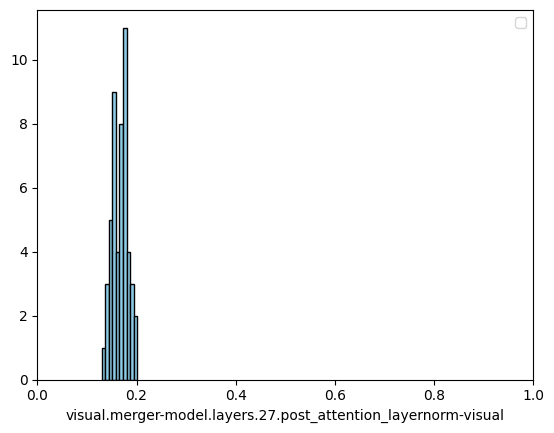

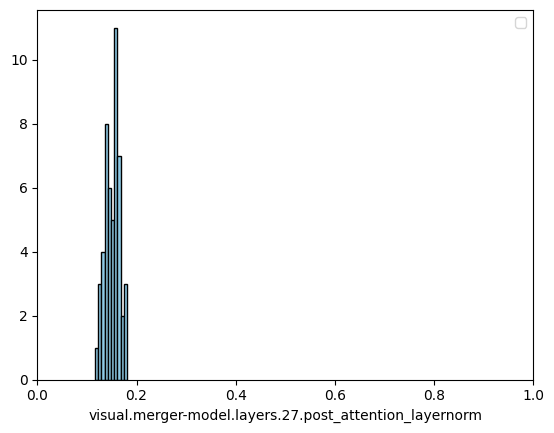

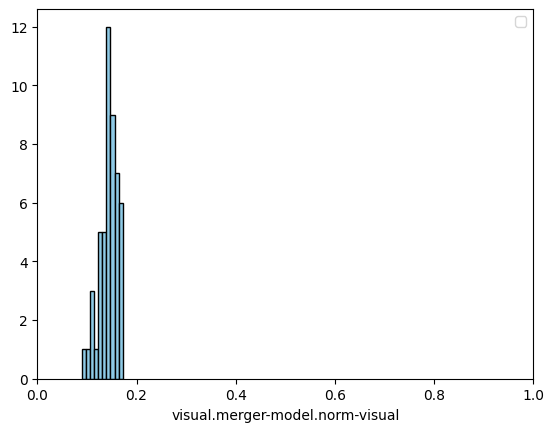

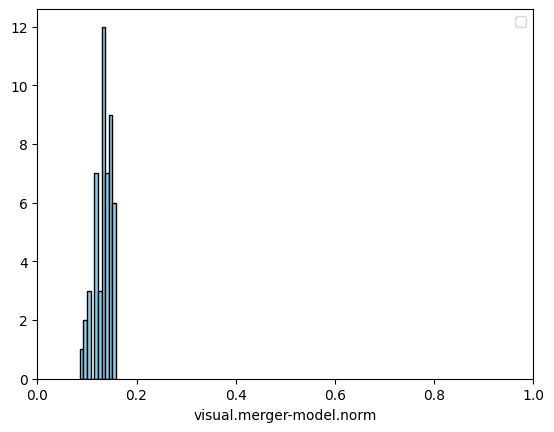

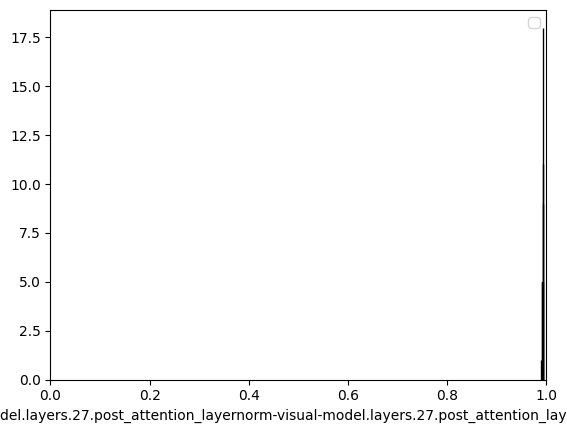

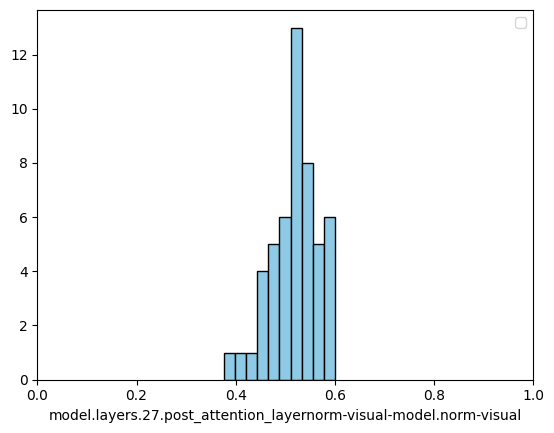

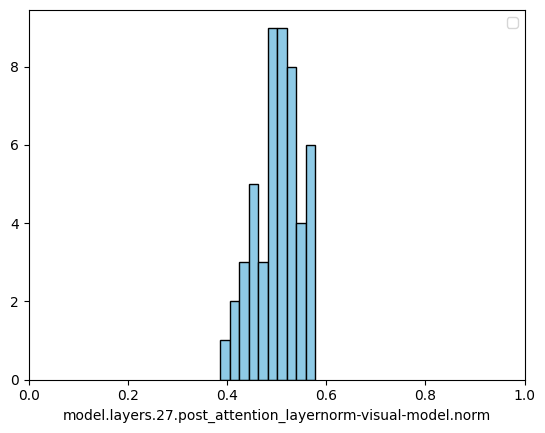

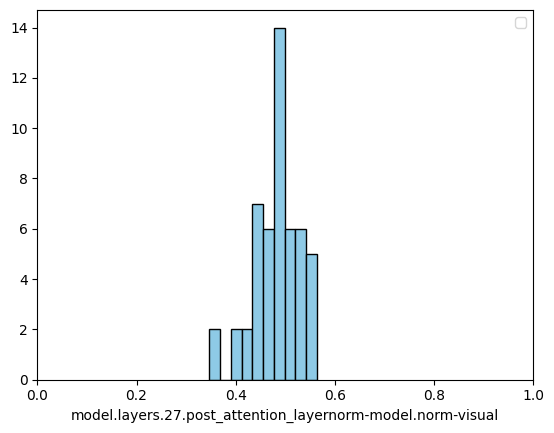

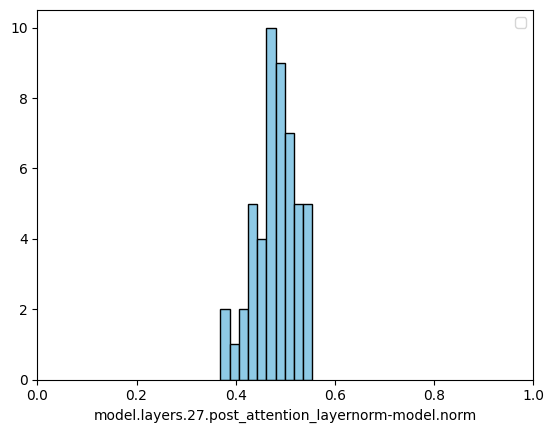

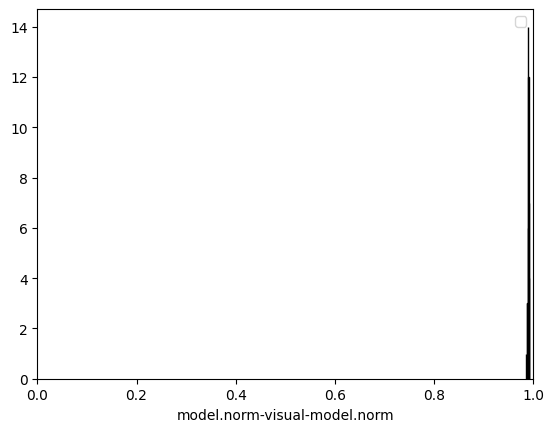

<Figure size 640x480 with 0 Axes>

In [76]:
n_graphs = len(comparison_names)
# fig, axes = plt.subplots(1, 3)

for idx in range(n_graphs):
    # ax = axes[idx]
    comparison_name = comparison_names[idx]
    cosine_sim = cosine_sims[idx]

    visualizations.histogram(
        data=cosine_sim,
        xlim=[0, 1],
        xlabel=comparison_name,
        show=True
    )